音频数据的长度：154350，采样率：44100


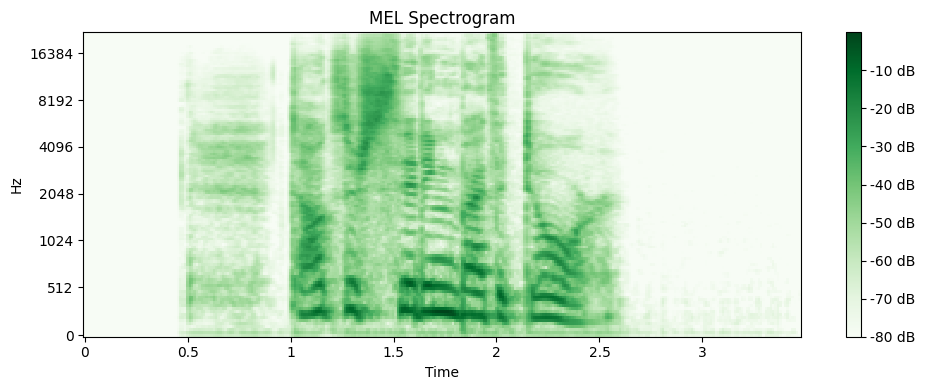

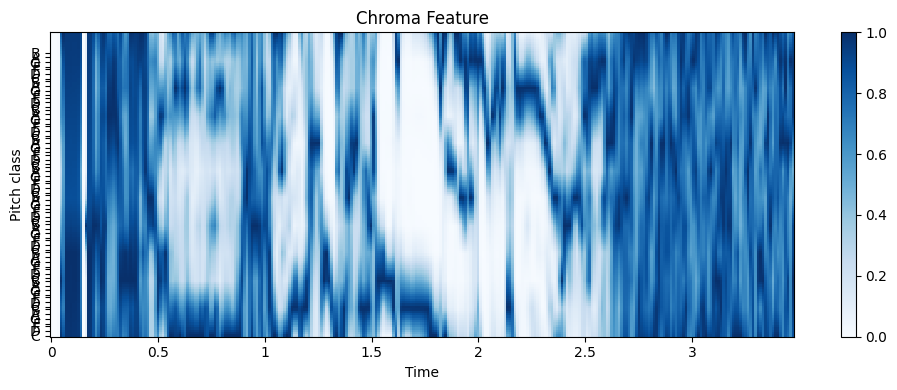

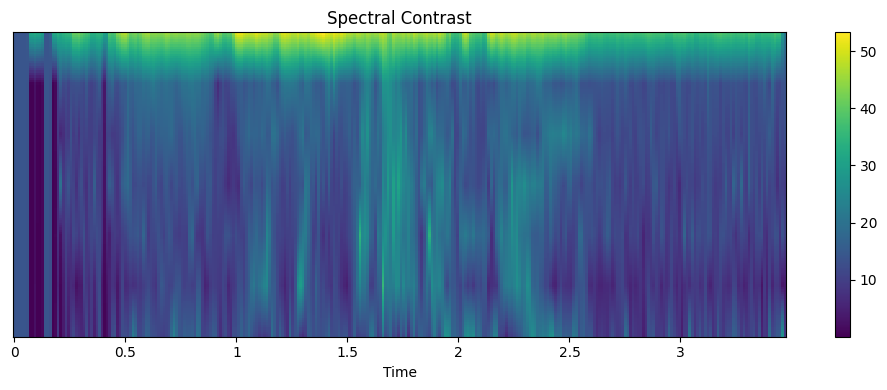

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.ndimage import zoom


target_duration = 3.5  
sr = 44100  
target_length = int(target_duration * sr)  


file_path = '/Users/chenxin/Desktop/语音情感分析-深度森林/wav/sad/03-01-04-01-02-01-14.wav'
audio_data, sr = librosa.load(file_path, sr=sr)


if len(audio_data) > target_length:
    audio_data = audio_data[:target_length]

elif len(audio_data) < target_length:
    padding = target_length - len(audio_data)
    audio_data = np.pad(audio_data, (0, padding), mode='constant')

print(f"音频数据的长度：{len(audio_data)}，采样率：{sr}")



target_size = (128, 300)

def resample_to_target(data, target_size):
    original_size = data.shape
    zoom_factors = (target_size[0] / original_size[0], target_size[1] / original_size[1])
    return zoom(data, zoom_factors, order=1)  # order=1 表示线性插值


S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB_resampled = resample_to_target(S_dB, target_size)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB_resampled, sr=sr, x_axis='time', y_axis='mel', cmap='Greens')
plt.colorbar(format='%+2.0f dB')
plt.title('MEL Spectrogram')
plt.tight_layout()
plt.show()


chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
chroma_resampled = resample_to_target(chroma, target_size)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_resampled, y_axis='chroma', x_axis='time', sr=sr, cmap='Blues')
plt.colorbar()
plt.title('Chroma Feature')
plt.tight_layout()
plt.show()

# 3. 计算并重采样 Spectral Contrast 图
spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
spectral_contrast_resampled = resample_to_target(spectral_contrast, target_size)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_contrast_resampled, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar()
plt.title('Spectral Contrast')
plt.tight_layout()
plt.show()

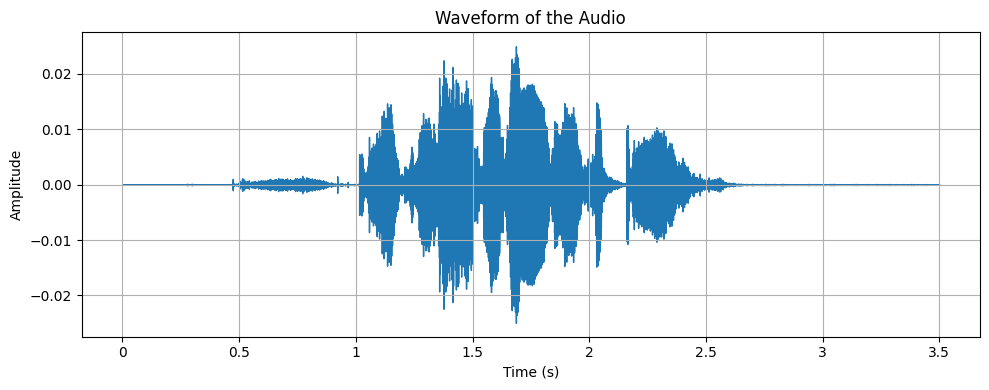

In [4]:

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_data, sr=sr)
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()


plt.show()

In [5]:
combined_tensor = np.stack([S_dB_resampled, chroma_resampled, spectral_contrast_resampled], axis=-1)

In [6]:
print(combined_tensor.shape)

(128, 300, 3)


In [16]:
import numpy as np
import librosa
import os
from scipy.ndimage import zoom


target_duration = 3.5 
sr = 44100 
target_size = (128, 300)  


def process_audio(file_path, sr, target_duration, target_size):
    audio_data, sr = librosa.load(file_path, sr=sr)
    target_length = int(target_duration * sr)

    if len(audio_data) > target_length:
        audio_data = audio_data[:target_length]
    elif len(audio_data) < target_length:
        padding = target_length - len(audio_data)
        audio_data = np.pad(audio_data, (0, padding), mode='constant')

 
    S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB_resampled = resample_to_target(S_dB, target_size)


    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    chroma_resampled = resample_to_target(chroma, target_size)


    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    spectral_contrast_resampled = resample_to_target(spectral_contrast, target_size)


    combined_tensor = np.stack([S_dB_resampled, chroma_resampled, spectral_contrast_resampled], axis=0)
    return combined_tensor


def resample_to_target(data, target_size):
    original_size = data.shape
    zoom_factors = (target_size[0] / original_size[0], target_size[1] / original_size[1])
    return zoom(data, zoom_factors, order=1)


base_path = '/Users/chenxin/Desktop/语音情感分析-深度森林/wav/'
emotions = ['angry', 'sad', 'happy', 'neutral', 'surprise', 'fear']
emotion_to_label = {emotion: idx for idx, emotion in enumerate(emotions)}



all_tensors = []
all_labels = []

for emotion in emotions:
    folder_path = os.path.join(base_path, emotion)
    label = emotion_to_label[emotion]
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            tensor = process_audio(file_path, sr, target_duration, target_size)
            all_tensors.append(tensor)
            all_labels.append(label)


combined_data = np.stack(all_tensors, axis=0)

all_labels = np.array(all_labels)



print("Combined Data Shape:", combined_data.shape)  
print("Labels Shape:", all_labels.shape)  
print("Labels Sample:", all_labels[:10]) 


Combined Data Shape: (4655, 3, 128, 300)
Labels Shape: (4655,)
Labels Sample: [0 0 0 0 0 0 0 0 0 0]


In [17]:
print(emotion_to_label)

{'angry': 0, 'sad': 1, 'happy': 2, 'neutral': 3, 'surprise': 4, 'fear': 5}


In [18]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(combined_data, all_labels, test_size=0.2, random_state=42)

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
  
        sample_input = torch.zeros(1, 3, 128, 300)
        sample_output = self.features(sample_input)
        num_features = sample_output.numel() // sample_output.size(0)
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x


model = CustomAlexNet(num_classes=6)


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

train(model, train_loader, criterion, optimizer)


def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import torch
import os


base_path = '/Users/chenxin/Desktop/语音情感分析-深度森林'  


def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
            all_probs.extend(probs.numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    return all_labels, all_preds, all_probs


all_labels, all_preds, all_probs = evaluate(model, test_loader)


conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, 
            xticklabels=['Angry', 'Sad', 'Happy', 'Neutral', 'Surprise', 'Fear'],
            yticklabels=['Angry', 'Sad', 'Happy', 'Neutral', 'Surprise', 'Fear'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(base_path, 'confusion_matrix.jpg'))
plt.show()


plt.figure(figsize=(10, 8))
num_classes = all_probs.shape[1]
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig(os.path.join(base_path, 'roc_curve.jpg'))
plt.show()


accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy score:")
print(accuracy)


recall = recall_score(all_labels, all_preds, average='macro')
print("Recall score:")
print(recall)

precision = precision_score(all_labels, all_preds, average='macro')
print("Precision score:")
print(precision)


f1 = f1_score(all_labels, all_preds, average='macro')
print("F1 score:")
print(f1)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, length = x.size()
        query = self.query_conv(x).view(batch_size, -1, length).permute(0, 2, 1)  # (B, L, C)
        key = self.key_conv(x).view(batch_size, -1, length)  # (B, C, L)
        value = self.value_conv(x).view(batch_size, -1, length)  # (B, C, L)
        
        attention = torch.bmm(query, key)  # (B, L, L)
        attention = self.softmax(attention)  # (B, L, L)
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, L)
        
        out = self.gamma * out + x
        return out

class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
     
        self.blstm = nn.LSTM(input_size=192, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        
  
        self.attention = SelfAttention(in_channels=119)  


        sample_input = torch.zeros(1, 3, 128, 300)
        sample_output = self.features(sample_input)
        sample_output = sample_output.view(1, -1, sample_output.size(2) * sample_output.size(3)).permute(0, 2, 1)  # (1, L, C)
        sample_output, _ = self.blstm(sample_output)
        sample_output = self.attention(sample_output)
        num_features = sample_output.size(1) * sample_output.size(2) 

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1, x.size(2) * x.size(3)).permute(0, 2, 1)  
        x, _ = self.blstm(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

model = CustomAlexNet(num_classes=6)


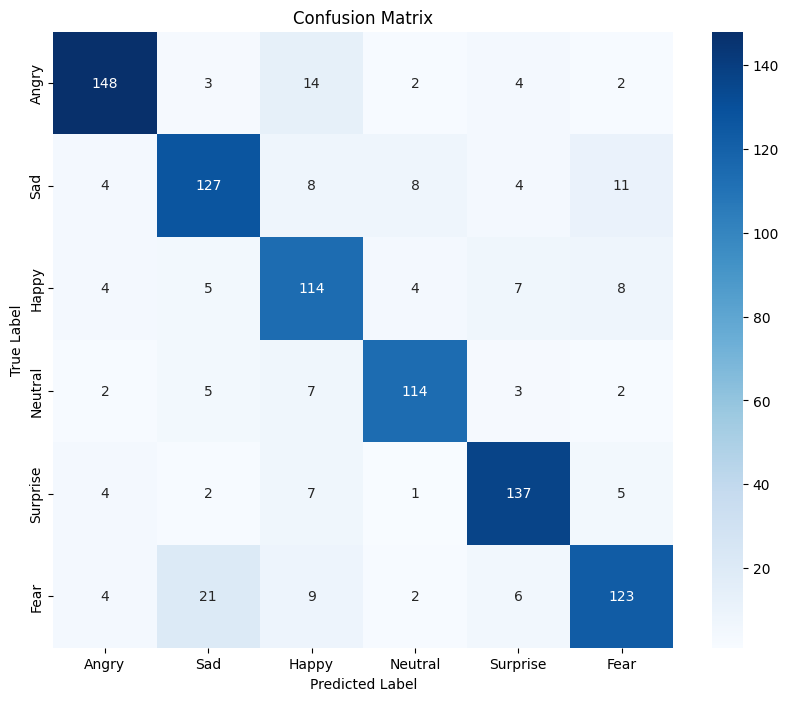

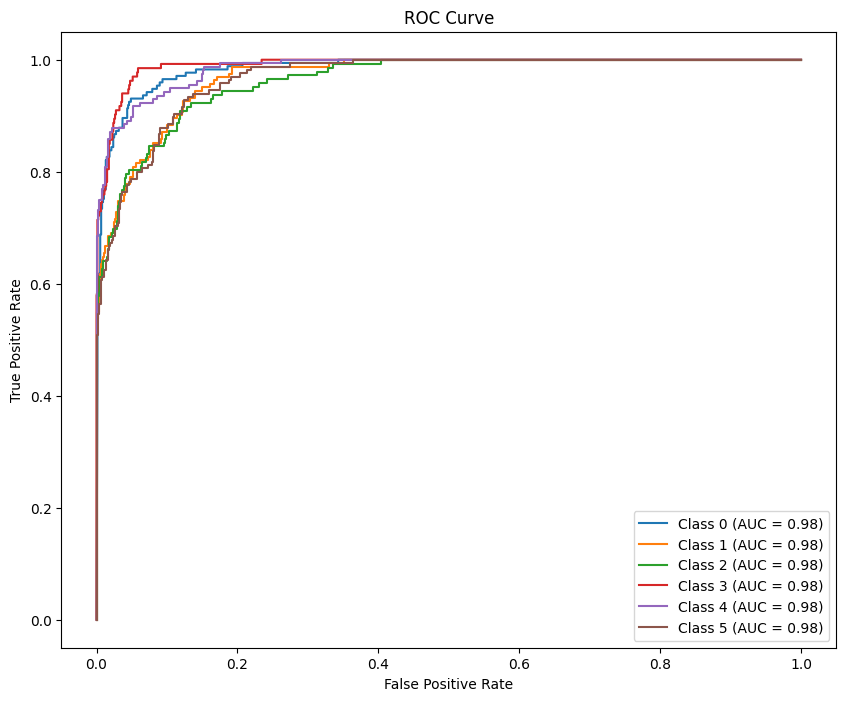

Accuracy score:
0.8195488721804511
Recall score:
0.8205102298291168
Precision score:
0.8205697870843754
F1 score:
0.8197734292292101


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import torch
import os


base_path = '/Users/chenxin/Desktop/' 


def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
            all_probs.extend(probs.numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    return all_labels, all_preds, all_probs


all_labels, all_preds, all_probs = evaluate(model, test_loader)


conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, 
            xticklabels=['Angry', 'Sad', 'Happy', 'Neutral', 'Surprise', 'Fear'],
            yticklabels=['Angry', 'Sad', 'Happy', 'Neutral', 'Surprise', 'Fear'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(base_path, 'confusion_matrix.jpg'))
plt.show()


plt.figure(figsize=(10, 8))
num_classes = all_probs.shape[1]
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig(os.path.join(base_path, 'roc_curve.jpg'))
plt.show()


accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy score:")
print(accuracy)


recall = recall_score(all_labels, all_preds, average='macro')
print("Recall score:")
print(recall)


precision = precision_score(all_labels, all_preds, average='macro')
print("Precision score:")
print(precision)


f1 = f1_score(all_labels, all_preds, average='macro')
print("F1 score:")
print(f1)


In [39]:
sum(all_labels==all_preds)/len(all_preds)

0.7

In [38]:
len(all_preds)

240

In [24]:
sum(all_labels==0)
# sum(all_labels==1)
# sum(all_labels==2)
# sum(all_labels==3)
# sum(all_labels==4)
# sum(all_labels==5)

39

In [10]:

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)

Test Accuracy: 100.00%


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, length = x.size()
        query = self.query_conv(x).view(batch_size, -1, length).permute(0, 2, 1)  # (B, L, C)
        key = self.key_conv(x).view(batch_size, -1, length)  # (B, C, L)
        value = self.value_conv(x).view(batch_size, -1, length)  # (B, C, L)
        
        attention = self.softmax(torch.bmm(query, key))  # (B, L, L)
        out = torch.bmm(value, attention)  # (B, C, L)
        out = self.gamma * out + x
        return out

class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # BLSTM 
        self.blstm = nn.LSTM(input_size=192, hidden_size=256, num_layers=3, batch_first=True, bidirectional=True)
        
       
        self.attention = SelfAttention(in_channels=119)  

       
        sample_input = torch.zeros(1, 3, 128, 300)
        sample_output = self.features(sample_input)
        sample_output = sample_output.view(1, -1, sample_output.size(2) * sample_output.size(3)).permute(0, 2, 1)  # (1, L, C)
        sample_output, _ = self.blstm(sample_output)
        sample_output = self.attention(sample_output)
        num_features = sample_output.size(1) * sample_output.size(2)  

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1, x.size(2) * x.size(3)).permute(0, 2, 1)  # (B, L, C)
        x, _ = self.blstm(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

    

model = CustomAlexNet(num_classes=6)

In [24]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train(model, train_loader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

train(model, train_loader, criterion, optimizer)


def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)

Epoch 1/2, Loss: 0.0000
Epoch 2/2, Loss: 0.0000
Test Accuracy: 87.11%


In [21]:

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)

Train Accuracy: 100.00%


In [22]:

torch.save(model.state_dict(), 'custom_alexnet_state_dict.pth')

In [2]:
print(model)

CustomAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blstm): LSTM(192, 256, num_layers=3, batch_first=True, bidirectional=True)
  (attention): SelfAttention(
    (query_conv): Conv1d(119, 14, kernel_size=(1,), stride=(1,))
    (key_conv): Conv1d(119, 14, kernel_size=(1,), stride=(1,))
    (value_conv): Conv1d(119, 119, kernel_size=(1,), stride=(1,))
    (softmax): Softmax(dim=-1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=60928, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_featu